## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand

from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Load Data

In [2]:
# loading entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/test_mocap/trajectories/'
trajectories = os.listdir(path)

## Data Cleansing and Exploration

In [ ]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i, time_bin in enumerate(trajectories):
    trajectory = loadmat(path + time_bin)
    trajectory = trajectory['trajectory'] 
    for i in range(trajectory.shape[1]):
        if np.isnan(trajectory[:, i]).all():
            nan_cols.append(i)

sampling_factor = 15
nan_cols = np.asarray(nan_cols)
if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
    sampled_trajectories = np.zeros(((trajectory.shape[0]*int(len(trajectories)/sampling_factor)), trajectory.shape[1]-3))
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-3))
    a = 0
    for i, time_bin in enumerate(trajectories):
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        trajectory = np.delete(trajectory, nan_cols, 1)
        idx = a*trajectory.shape[0]
        idx_2 = i*trajectory.shape[0]
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
        if i % sampling_factor == 0 and sampled_trajectories.shape[0]-idx >= trajectory.shape[0]:
            sampled_trajectories[idx:idx+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
            a+=1
        
print(sampled_trajectories.shape)
print(all_trajectories.shape)

## Linearity/Nonlinearity Analysis:

In [ ]:
# dims varition trend plot:
dim = 'y'
if dim == 'x':
    start = 3
elif dim == 'y':
    start = 4
elif dim == 'z':
    start = 5

fig = plt.figure()
time_range = sampled_trajectories.shape[0]
n_dims = int(sampled_trajectories.shape[1]/3)-1
diff_array = []
dim_max_change = 0
max_change = float('-inf')
for i in range(start,sampled_trajectories.shape[1], 3):
    diff = np.asarray(sampled_trajectories[:, start-3]) - np.asarray(sampled_trajectories[:, i])
    if np.max(np.absolute(diff))>max_change:
        max_change = np.absolute(np.max(diff))
        dim_max_change = i
    diff_array.append(diff)
    plt.plot(np.arange(time_range), diff) 

plt.xlabel('Time(ms)')
plt.ylabel('Difference')
plt.ylim([-50, 50])

print(dim_max_change)

In [ ]:
# Exploring linearity at the level of single dimensions bins
x1, x2 = sampled_trajectories[0::, 0], sampled_trajectories[0::, 27]
print(sampled_trajectories[0:time_range, 1].shape)
m, b = np.polyfit(x1, x2, 1)

fig = plt.figure()
plt.scatter(x1, x2)
plt.plot(x1, m*x1 + b)

## Dimensionality Reduction: PCA

In [ ]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(all_trajectories)

plt.scatter(np.arange(sampled_trajectories.shape[1]), pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[0:3]))
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(sampled_trajectories)
reduced_traj.shape

print(np.cov(np.transpose(reduced_traj)))

## Incremental Covariance Matrix

In [ ]:
cov_init = np.cov(np.transpose(first_trajectories))
cov_sampled = np.cov(np.transpose(sampled_trajectories))
vars_ = np.zeros((cov_init.shape[0], 2))
means_ = np.zeros((first_trajectories.shape[1],1))
for i in range(cov_init.shape[0]):
    vars_[i, 0] = cov_init[i,i]
    vars_[i, 1] = cov_sampled[i,i]
    means_[i] = np.mean(first_trajectories[:, i])

# update initial covariance
n_init = first_trajectories.shape[0]
for i, time_bin in enumerate(trajectories):
    if i >= sampling_factor:
        print('trajectory: ', i)
        print(path + time_bin)
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        trajectory = np.delete(trajectory, nan_cols, 1)
        for a, row in enumerate(trajectory):
            if a%1800==0:print(a)
            for j, obs in enumerate(row):
                new_mean_j = (n_init*means_[j] + obs)/(n_init + 1)
                for k in range(j, len(row)):
                    cov_temp = cov_init[j,k]
                    new_mean_k = (n_init*means_[k] + row[k])/(n_init + 1)
                    cov_init[j,k] = (n_init/n_init + 1)*cov_temp + ((1/n_init)*(obs-new_mean_j)*(row[k]-new_mean_k))
                    cov_init[k,j] = cov_init[j,k]
                                                                    
            n_init = n_init+1

## Dimensionality Reduction: Kernel-PCA

In [ ]:
kPCA = KernelPCA(n_components=3, kernel = 'linear')
reduced_traj_k = kPCA.fit_transform((all_trajectories))
reduced_traj_k.shape

## Data Exploration

In [ ]:
# plotting histogram of the x,y and z location of the first dimension of high-d trajectory
# x-location
fig = plt.figure(1)
n, bins, patches = plt.hist(x=trajectory[:, 0], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 3], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 6], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 9], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x location')
plt.ylabel('Occurences')


# y-location
fig = plt.figure(2)
n, bins, patches = plt.hist(x=trajectory[:, 1], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 4], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 7], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 10], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('y location')
plt.ylabel('Occurences')


# z-location
fig = plt.figure(3)
n, bins, patches = plt.hist(x=trajectory[:, 2], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 5], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 8], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 11], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('z location')
plt.ylabel('Occurences')

In [ ]:
# plotting histogram of the x-location of the first dimension of non-reduced trajectory
n, bins, patches = plt.hist(x=trajectory[:, 0], bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x location')
plt.ylabel('Frequency')

# plotting histogram of the x-location of the first dimension for reduced trajectory (PCA)
n, bins, patches = plt.hist(x=reduced_traj[:, 0], bins='auto', 
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('PC 1')
plt.ylabel('Frequency')

In [ ]:
traj_length = 900

fig = plt.figure(1)
# plotting 3D trajectory taking first 3 dimensions of the high-d trajectory
ax = plt.axes(projection='3d')
zdata = trajectory[0:traj_length, 12]
xdata = trajectory[0:traj_length, 13]
ydata = trajectory[0:traj_length, 14]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

fig = plt.figure(2)
# plotting 3D reduced trajectory (PCA)
ax = plt.axes(projection='3d')
zdata = reduced_traj[0:traj_length, 2]
xdata = reduced_traj[0:traj_length, 0]
ydata = reduced_traj[0:traj_length, 1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

## Entropy Analysis

### Helper functions

In [ ]:
def prob_vector(raw_data, max_size, min_, decimals=1):
    rounded_data = [(round(x * 10**(decimals)))/(10**decimals) for x in raw_data]
    sorted_data = np.sort(rounded_data)
    sorted_data = np.array(sorted_data, dtype=np.float64)

    already_seen = []
    prob_vector = np.zeros((max_size+1))
    occurrences = 0
    idx = 0
    for datapoint in sorted_data:
        if datapoint not in already_seen:
            occurrences = np.count_nonzero(sorted_data == datapoint)
            already_seen.append(datapoint)
            idx = int((datapoint - min_)/(1/10**decimals))
            prob_vector[idx] = (occurrences/len(sorted_data))
    
    return prob_vector

In [ ]:
def get_mPE_matrix(reduced_traj, bins_number=30, traj_number=30, orders=[3]):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx = 0
            idx_1 = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = i*bins_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                [HH,hh_norm]=mPE(traj, order)
                mPE_vector[i, idx , a] = HH
                idx += 1
                
    return mPE_vector

In [ ]:
def get_vel_matrix(trajectory, bins_number=30, traj_number=30, least_varaince_zdim=8*3):
    f_s = 300
    vel_matrix = np.zeros((bins_number, traj_number))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for i in range(bins_number):
        idx = 0
        idx_1 = 0
        for j in range(0, traj_length*traj_number, traj_length):
            idx_1 = i*bins_number*traj_length 
            traj = trajectory[idx_1 + j: idx_1 + j + traj_length, least_varaince_zdim:least_varaince_zdim+3]
            vel_bin = 0
            last_point = traj[0, :]
            for point in traj:
                vel_bin = vel_bin + distance.euclidean(point, last_point)
                last_point = point
            vel_matrix[i, idx] = vel_bin
            idx += 1
                
    return vel_matrix

In [ ]:
def behavioural_entropy(behav_time_series, bins_number, traj_number, mode):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx = 0
            idx_1 = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = i*bins_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                if mode=='PE':
                    [HH,hh_norm]=mPE(traj, order)
                elif mode=='Shannon':
                    HH = entropy(traj, base=2)
                mPE_vector[i, idx , a] = HH
                idx += 1
                
    return mPE_vector

In [ ]:
def joint_prob_matrix(x, y, n_behaviours, truncation_decimal=1):
    # Checking that the dimensions are in the right order
    if x.shape[0] < x.shape[1]:
        x = np.transpose(x)
    if y.shape[0] < y.shape[1]:
        y = np.transpose(y)
    
    # rounding reduced trajectory to 2 decimal place
    rounded_x = [(round(i * 10**(decimals)))/(10**decimals) for i in x]
    rounded_x = np.asarray(rounded_x)
    # finding max and min of reduced trajectory data
    min_ = float('inf')
    max_ = float('-inf')
    for time_point in range(rounded_x.shape[0]):
        for positions in range(rounded_x.shape[1]):
            if rounded_x[time_point, positions] > max_:
                max_ = rounded_x[time_point, positions]
            elif rounded_x[time_point, positions] < min_:
                min_ = rounded_x[time_point, positions]

    min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
    max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
    max_size = int((max_ - min_)/(1/(10**truncation_decimal)))
    # concatating joint data (x and y)
    joint_data = np.concatenate(rounded_x, y, axis=1)

    already_seen = []
    joint_prob_matrix = 2*np.zeros((max_size, n_behaviours))
    occurrences, idx_location, idx_behaviour = 0, 0, 0
    for joint_array in rounded_x:
        if joint_array not in already_seen:
            occurrences = np.count_nonzero(sorted_data == joint_array)
            already_seen.append(joint_array)
            found = True
            while found == False:
                idx_location = np.random.randint(max_size)
                if joint_prob_matrix[idx_location, idx_behaviour] == 2:
                    found = False
                    break
            idx_behaviour = joint_array[joint_data.shape[1]]
            joint_prob_matrix[idx_location, idx_behaviour] = (occurrences/joint_data.shape[0])
    
    return prob_vector

### Entropy time-evolution

In [12]:
# Entropy Calculation:
# - Divide entire trajetcory in 'bins_number' bins
# - Divide each bin for 'traj_number' trajectories
# - Calculate mPE for each of these trajectories 
minutes = 6
f_s = 300
bin_length = fs*60*minutes

bins_number = int(reduced_traj/bin_length)
traj_number = 30
orders = [5]

mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders)

/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be rem

Text(0, 0.5, 'mean mPE')

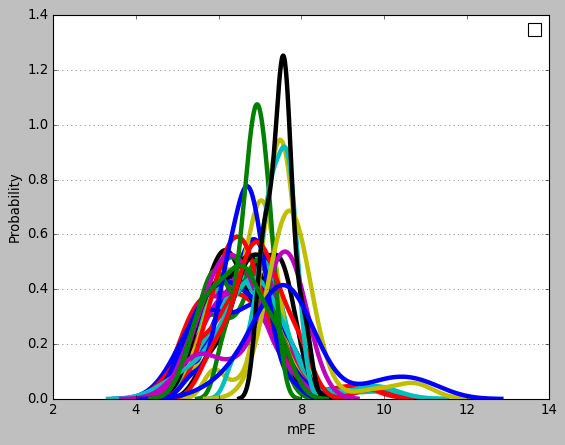

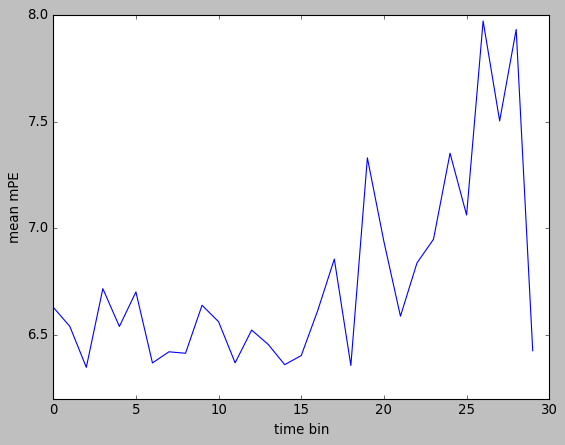

In [13]:
# entropy distribution visualization
# plotting mpE of the first bin 

mode = 'distribution'
bin_n = 2
order_n = 0
fig = plt.figure()

# plotting histograms of two different bins
if mode == 'hist':
    n, bins, patches = plt.hist(x = mPE_vector[bin_n, :, order_n] , bins='auto', color='green',
                                alpha=0.7, rwidth=0.85)
    n, bins, patches = plt.hist(x= mPE_vector[mPE_vector.shape[0]-5, :, order_n] , bins='auto', color='red',
                                alpha=0.7, rwidth=0.85)

# plotting mPE continuous distribution as a function of time 
elif mode =='distribution':
    bins = np.arange(30)
    means = np.zeros((len(bins),1))
    for i, bin_n in enumerate(bins):
        means[i] = np.mean(mPE_vector[bin_n, :, order_n])
        ax = sns.displot(mPE_vector[bin_n, :, order_n], hist=False, kde=True, 
                          bins=0.1, 
                          hist_kws={'edgecolor':'black'},
                          kde_kws={'linewidth': 4})
        
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mPE')
plt.ylabel('Probability')

fig = plt.figure()
plt.plot(np.arange(len(bins)), means)
plt.xlabel('time bin')
plt.ylabel('mean mPE')

Text(0, 0.5, 'P-Value')

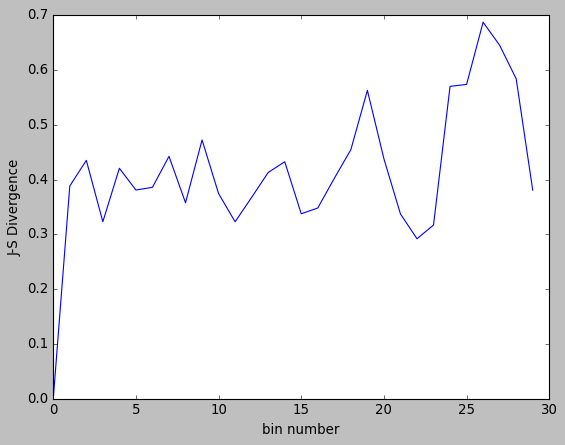

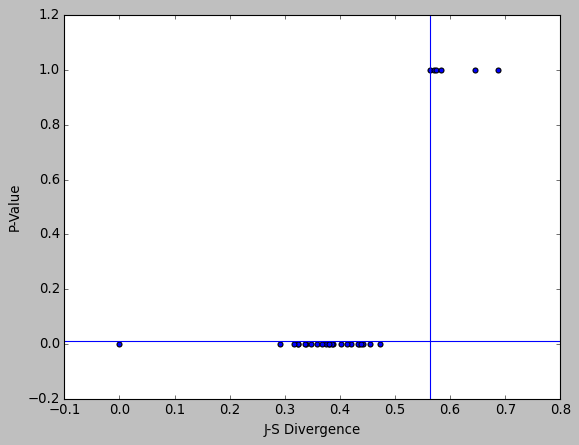

In [31]:
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[traj, bin_, order] > max_:
                max_ = mPE_vector[traj, bin_, order]
            elif mPE_vector[traj, bin_, order] < min_:
                min_ = mPE_vector[traj, bin_, order]

truncation_decimal = 1
min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

# plotting J-S divergence as a function of bin number
compare_to = prob_vector(mPE_vector[0, :, 0], max_size, min_)
js_vector = np.zeros((mPE_vector.shape[0]))
ks_vector = np.zeros((mPE_vector.shape[0], 2))
ks_and_div = np.zeros((mPE_vector.shape[0], 2))
significance_lev = 0.01
for i in range(mPE_vector.shape[0]):
    js_vector[i] = distance.jensenshannon(prob_vector(mPE_vector[i, :, 0], max_size, min_), compare_to)
    ks_and_div[i, 0] = js_vector[i]
    if i > 0:
        ks_vector[i, :] = stats.ks_2samp(mPE_vector[i, :, 0], mPE_vector[0, :, 0])
        if ks_vector[i, 1] <= significance_lev:
            ks_and_div[i, 1] = 1
        else:
            ks_and_div[i, 1] = 0
            
fig = plt.figure()
# plotting velocity profile of mouse (point-wise)
plt.plot(np.arange(mPE_vector.shape[0]), js_vector)
plt.xlabel('bin number')
plt.ylabel('J-S Divergence')

js_rejected = np.where(ks_and_div[:,1] == 1)
js_th = float('inf')
for i in js_rejected[0]:
    if ks_and_div[i, 0] < js_th:
        js_th = ks_and_div[i, 0]
    
fig = plt.figure()
plt.scatter(ks_and_div[:, 0], ks_and_div[:, 1])
plt.axhline(y=significance_lev, xmin=0, xmax=1)
plt.axvline(x=js_th, ymin=0, ymax=1.2)
plt.xlabel('J-S Divergence')
plt.ylabel('P-Value')

### Velocity vs Entropy

In [33]:
# Calculate instantaneous velocity of each datapoint (maybe only consider x-y dims)
lest_varaince_dim = 8*3
minutes = 6
f_s = 300
bin_length = fs*60*minutes

bins_number = int(reduced_traj/bin_length)
traj_number = 30
orders = [5]
vel_matrix = get_vel_matrix(trajectory)

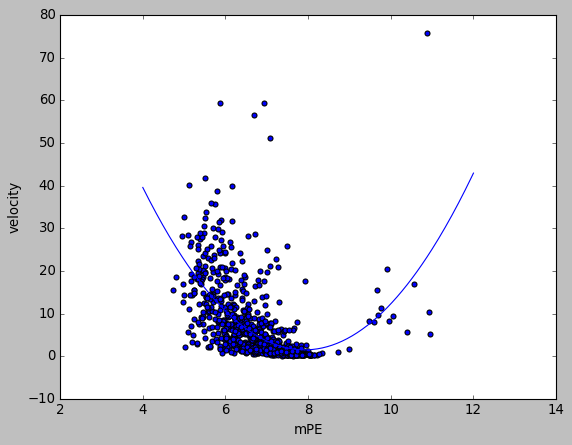

In [47]:
# plotting bin-velocity against corresponding mPE
vel_vector = vel_matrix.flatten()
mPE_vector_ = mPE_vector.flatten()
p = np.polyfit(mPE_vector_, vel_vector, 2)
x_new = np.linspace(4,12,200)
ffit = np.polyval(p, x_new)

fig = plt.figure()
plt.scatter(mPE_vector_, vel_vector)
plt.xlabel('mPE')
plt.ylabel('velocity')
plt.plot(x_new, ffit)

### Entropy Behavioral Analysis

In [ ]:
# load behavioural time series and corresponding marker location time series
x = loadmat('[ENTER HERE].mat')
trajectory = x['']
